### Chapter 6 Figures

Figures that accompany the XGB-TBSContext. 

Assumes that the data output from feature analsysis is located in 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import ranksums, wilcoxon
import numpy as np

import pybedtools
%matplotlib inline

#to ensure the sequences are not truncated
pd.set_option('display.max_colwidth', -1)

#Set path for the figures
figure_path = "../Results/Chapter6/Figs"

## Calculate Wilcoxon ranksum test and the effect size

### Effect size

This is adapted from: https://github.com/bagrow/datatools/blob/master/bin/ranksum

In this,we are using Cohens effect size, which can be interpreted as follows:
    - None 0
    - Small 0.2
    - Medium 0.5
    - Large 0.8
    - Very large 1.3
    
 I should provide some details for interpreting effect size

In [2]:
def get_stat_wilcoxon_effect_size(sample1,sample2):
    X1 = np.array(sample1)
    X2 = np.array(sample2)
    n1 = len(sample1)
    n2 = len(sample2)
    m1 = np.mean(X1)
    m2 = np.mean(X2)
    s1 = np.std(X1,ddof=1)
    s2 = np.std(X2,ddof=1)

    s = np.sqrt( ((n1-1)*s1**2 + (n2-1)*s2**2)/(n1+n2) )
    return ranksums(sample1,sample2)[1],(m2-m1)/s

# Machine learning features

#### Feature importance by eliminating one, sequentially

The main observation here is that the DNase and the TSS as the most informative features. Next, we eliminate all least contributing features and only retain the core features as follows:
* Dnase
* Tss
* Phastcons
* max Kmer score
* Hg-dn normalized to noise

In [3]:
# Set to this for display, but to paper for the thesis
sns.set(style="ticks", context="paper")

## Comparing machine learning algorithms

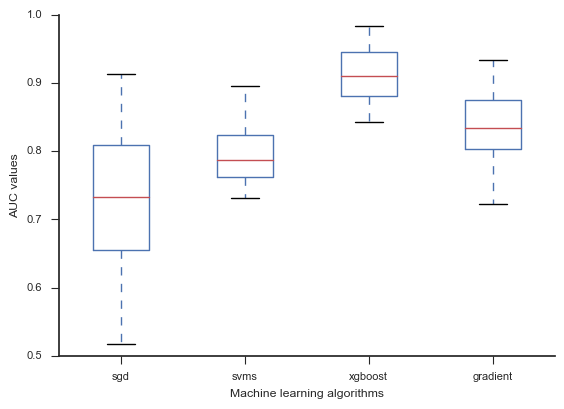

In [4]:
TF_models = pd.read_table("../Results/compare_algorithms.txt", index_col="Tf_name")
TF_models.pop("Unnamed: 5")
ax = TF_models.plot.box()
ax.set_ylabel("AUC values")
ax.set_xlabel("Machine learning algorithms")
sns.despine()
fig = ax.get_figure()
fig.savefig("%s/Compare_algorithms.pdf" % figure_path)

#### Statistical significance of the performance difference

In [5]:
# remove index to get the cohens effect size as well

print "Sgd:", get_stat_wilcoxon_effect_size(TF_models.sgd, TF_models.xgboost)[0]
print "Svms:", get_stat_wilcoxon_effect_size(TF_models.svms, TF_models.xgboost)[0]
print "gradient:", get_stat_wilcoxon_effect_size(TF_models.gradient, TF_models.xgboost)[0]

Sgd: 9.1554578324e-06
Svms: 3.92903582788e-05
gradient: 0.0012865616351


### Get infromative names for features

In [6]:
TF_scores_all = pd.read_table("../Results/TF_scores_feature_importance_recursive_pop2.txt", index_col="Tf_name")

In [7]:
map_names = {}
for feat in list(TF_scores_all.columns):
    map_names[feat] = feat
map_names["kmer_score"] = "sum_kmer_score"
map_names["dn_hg_score2"] = "hg_dn_score"
map_names["kmer_score"] = "sum_kmer_score"
map_names["dnase"] = "dnase"
map_names["max_kmer_score"] = "max_kmer_score"
map_names["phyloP100way"] = "phyloP100way"
map_names["None"] = "None"

In [8]:
def map_names_fun(df):
    """
    Takes a dataframe and renames the column names
    """
    df.columns = [map_names[feat] for feat in list(df.columns)]
    return df

### 1. Feature importance using all features via recursive feature elimination

We assess for the contribution to model's performance through elimination. The feature that leads to greatest drop in performance is the most informative: DNase. 

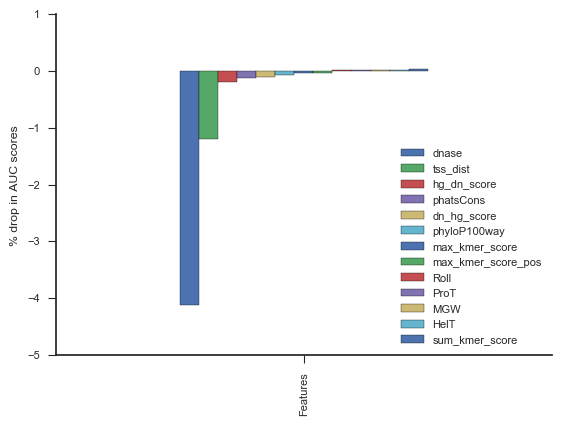

In [9]:
TF_scores_all = pd.read_table("../Results/TF_scores_feature_importance_recursive_pop2.txt", index_col="Tf_name")

TF_scores_all = TF_scores_all.T
TF_scores_all["Features"] = TF_scores_all.T.mean()
TF_scores_all = TF_scores_all.T
del TF_scores_all["Unnamed: 15"]

TF_scores_all = map_names_fun(TF_scores_all)
#[map_names[feat] for feat in list(TF_scores_best.columns)]

abc = ((TF_scores_all.T["Features"] - TF_scores_all.T["Features"].All)*100)
abc.sort_values(inplace=True, ascending=True)
abc_df_pop = pd.DataFrame(abc).T
del abc_df_pop["All"]

#abc_df_pop.index.name = 'Features'
ax= abc_df_pop.plot.bar()
ax.set_ylabel("% drop in AUC scores")
#ax.set_xlabel("Features")
sns.despine()
fig = ax.get_figure()
fig.savefig("%s/feature_importance_all.pdf" % figure_path)
# abc = (TF_scores_best.T["Ave."].sort_values(ascending=False) - TF_scores_best.T["Ave."].max()) * 100

# ax= pd.DataFrame(abc).T.plot.bar()
# fig = ax.get_figure()

In [10]:
get_stat_wilcoxon_effect_size(TF_scores_all.All, TF_scores_all.dnase)

(0.11017891120321074, -0.45878446974257769)

In [11]:
wilcoxon(TF_scores_all.All, TF_scores_all.dnase)

WilcoxonResult(statistic=0.0, pvalue=5.9569779074563595e-05)

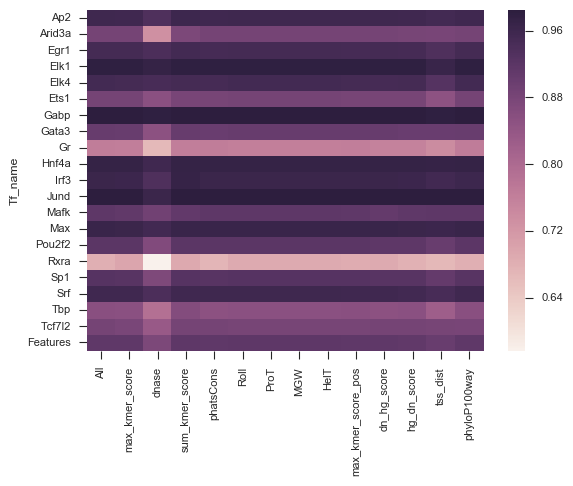

In [12]:
sns.heatmap(TF_scores_all)

In [43]:
fig.savefig("%s/feature_importance_recursive.png" % figure_path)

###  2. Feature importance by addition

We test the feature importance by starting with the baseline model (dnase and max_kmer_score), test the contribution of each of the additional features, as well as the value of using all the best features. This tell us how important a feature is when added to the baseline model of DNase and max_kmer score.

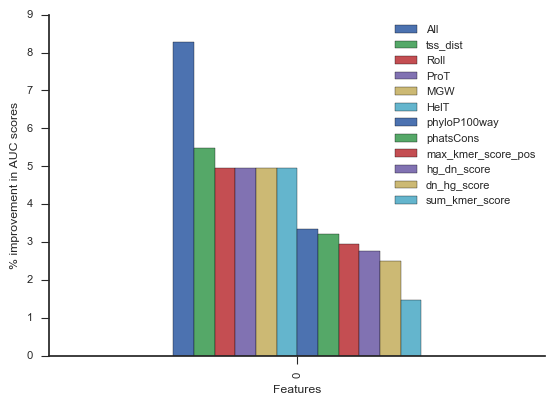

In [13]:
TF_scores_all = pd.read_table("../Results/TF_scores_feature_importance_recursive_all.txt", index_col="Tf_name")
#TF_scores_all.columns = [map_names[feat] for feat in list(TF_scores_all.columns)]
TF_scores_all =map_names_fun(TF_scores_all) 
test_df = pd.DataFrame(((TF_scores_all.T - TF_scores_all["None"]).T.mean())*100)
test_df.sort_values(by=0, ascending=False, inplace=True)
test_df = test_df.T

del test_df["None"]

ax = test_df.plot(kind="bar")

ax.set_ylabel("% improvement in AUC scores")
ax.set_xlabel("Features")
sns.despine()
fig = ax.get_figure()
fig.savefig("%s/feature_importance_additive_all.pdf" % figure_path)

In [45]:
test_kmers = TF_scores_all[["All","sum_kmer_score", "max_kmer_score_pos","None"]]

From the above, we can clearly demonstrate the performance of TSS and DNase, but not of the rest of the features. Therefore we perform feature importance analysis using the best six.  

### 3. Narrowing down to best 6 informative sites

After confirming the overal feature importance, we norrow down to 6 most informative features, and test them further. Here, we are specifically| intersted in eliminating feature with similar informaton. This way, we can confidently measure the importance of each feature individually. 

The only change in the ranking from this is the importance of the tss outperformed by *k*-mer feature. 

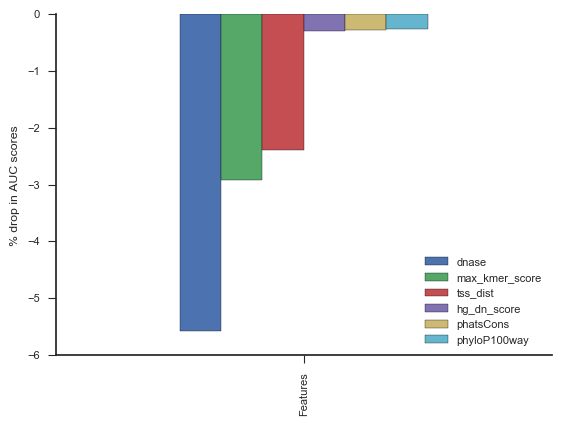

In [14]:
TF_scores_best_6 = pd.read_table("../Results/TF_scores_feature_importance_recursive_pop_best6.txt", index_col="Tf_name")

del TF_scores_best_6["Unnamed: 8"]
TF_scores_best_6 = map_names_fun(TF_scores_best_6)

TF_scores_best_6 = TF_scores_best_6.T
TF_scores_best_6["Features"] = TF_scores_best_6.T.mean()
abc = ((TF_scores_best_6["Features"] - TF_scores_best_6["Features"].All)*100)
abc.sort_values(inplace=True, ascending=True)
abc_df = pd.DataFrame(abc).T
del abc_df["All"]
ax= abc_df.plot.bar()
sns.despine()
ax.set_ylabel("% drop in AUC scores")
#ax.set_xlabel("Features")
fig = ax.get_figure()
fig.savefig("%s/feature_importance_best6.pdf" % figure_path)

In [15]:
get_stat_wilcoxon_effect_size(TF_scores_best_6.T.All,TF_scores_best_6.T.max_kmer_score)

(0.068183650364699852, -0.47557472816281959)

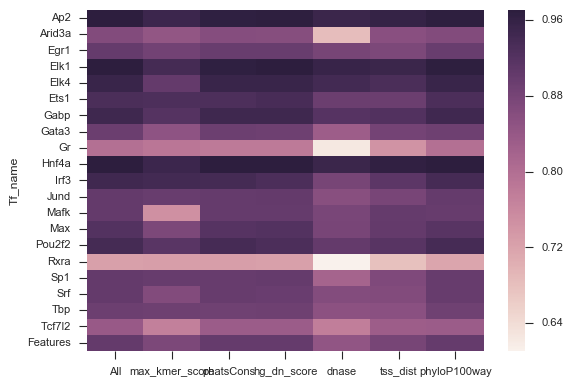

In [16]:
sns.heatmap(TF_scores_best_6.T)

### 4. TF-specific feature importance

With the figure below, it is easy to observe TF-specific importance of the features. For example, the Arid3a greatly depend on the dnase data and could be linked to poor quality of the *k*-mer model. On the other hand, Mafk is distinct in that it depends more on the *k*-mer model for predictive modelling. 

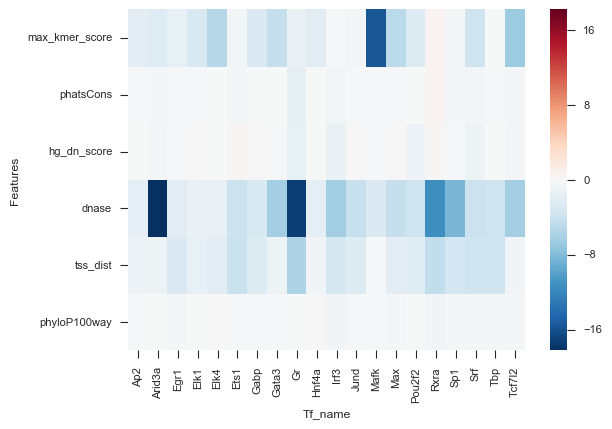

In [17]:
tf_specific = ((TF_scores_best_6 - TF_scores_best_6.T["All"])*100)
tf_specific.drop("All", inplace=True)
del tf_specific["Features"]
ax = sns.heatmap(tf_specific)
ax.set_ylabel("Features")
plt.savefig("%s/feature_importance_tf_specific.pdf" % figure_path, bbox_inches='tight')

In [18]:
get_stat_wilcoxon_effect_size(TF_scores_best_6.T.All,TF_scores_best_6.T.dnase)

(0.016289081250027936, -0.69877045593066578)

### 5. Feature importance figures combined combined: Figure 6.7

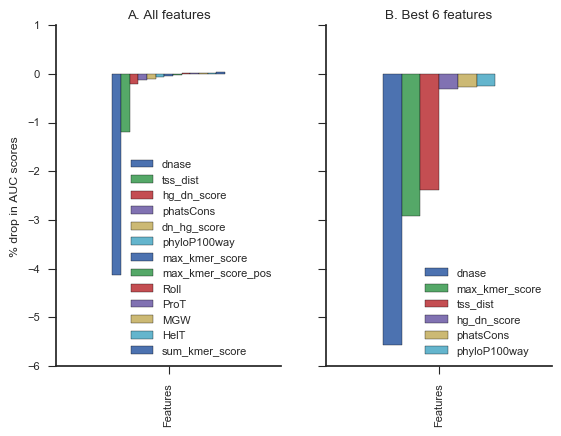

In [19]:
#fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True)
abc_df_pop.plot.bar(ax=ax1)
abc_df.plot.bar(ax=ax2)
#fig = ax.get_figure()
ax1.set_title('A. All features')
ax2.set_title('B. Best 6 features')
ax1.set_ylabel("% drop in AUC scores")
#ax1.set_xlabel("Training features")
ax1.legend(loc='lower right')
sns.despine()
fig.savefig("%s/feature_importance_best_all.pdf" % figure_path)

### 6. The contribution of the different shape features

In [20]:
TF_scores_shape = pd.read_table("../Results/TF_scores_feature_importance_recursive_shape.txt", index_col="Tf_name")

TF_scores_shape = map_names_fun(TF_scores_shape)
#sns.heatmap(tst3.T/tst3.T.max(), annot=True)

We observe that the performance of the model with any of the shape features is similar....there is no difference in performance among the features. However, I may need to test this further and confirm the contribution of the individual features to the performance of the model. 

The figure shows how percentage contribution of the shape features to the model's performance. 

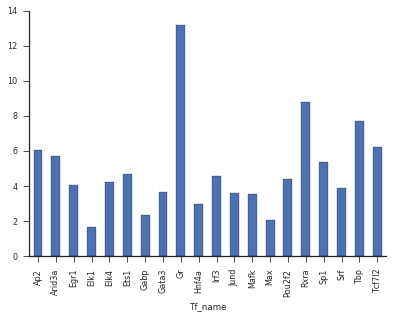

In [58]:
axes = ((TF_scores_shape.T - TF_scores_shape["None"])*100).T["All"].plot.bar()
#axes.yaxis_inverted()
#sns.set(style="ticks")
sns.despine()

#### b) Stacked bar plot

Provides the following information:
- A similar level of feature contribution by all the shape features
- Eliminating the all shape features leads to significant drop in performance
- Therefore, in the absence of other features...shape information provides significant performance improvement
- We can confirm significant contribution of shape features to model quality (0.03, Wilcoxon rank sum test; -0.57, Cohens effect size)

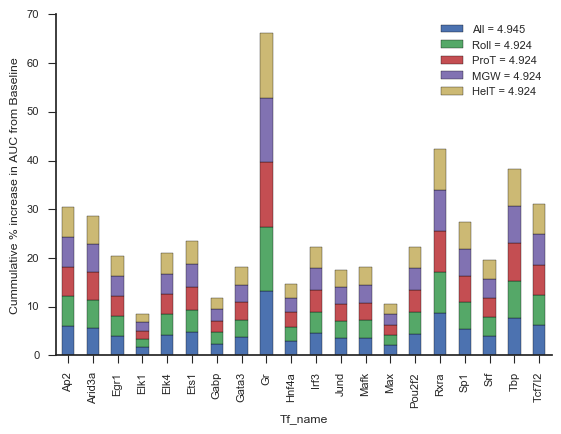

In [21]:
#sns.set(style="ticks")

shape_df = ((TF_scores_shape.T - TF_scores_shape["None"])*100).T
del shape_df["None"]
axes = shape_df.plot.bar(stacked=True)
ave_additive = shape_df.mean()
leg = list(shape_df.columns)
new_leg = []
for i in leg:
    new_leg.append("%s = %.3f" % (i,ave_additive[i]))
axes.legend(new_leg,loc='best')
axes.set_ylabel("Cummulative % increase in AUC from Baseline")
sns.despine(right=True)
plt.savefig("%s/feature_importance_dna_shape_additive.png" % figure_path, bbox_inches='tight')

### 7.  Contribution of noise or preferred k-mers to model quality

What is the overall contribution of the k-mer frequency difference to the prediction accuracy of the model?

Celarly, both provide some competitive advantage to the perfomance of the model, but preferred k-mers have the greatest benefit when combined with the baseline model. However, this advantage is not statistically significant (0.12982179737652688, Wilcoxon; -0.41421912013960499, Cohens effect size)

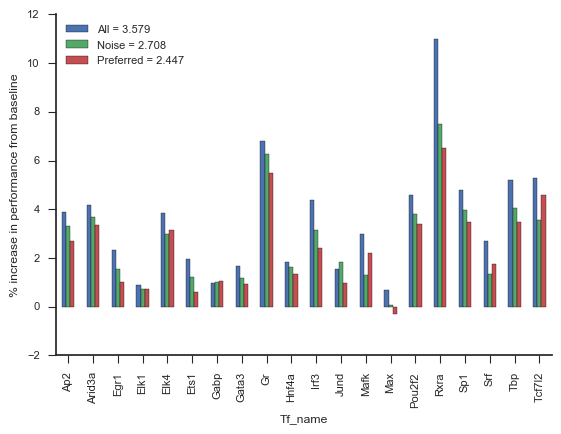

In [23]:
TF_scores_noise= pd.read_table("../Results/TF_scores_feature_importance_recursive_noise.txt", index_col="Tf_name")
del TF_scores_noise["Unnamed: 5"]
noise_df = ((TF_scores_noise.T - TF_scores_noise["None"])*100).T
del noise_df["None"]
noise_df = noise_df.T
#noise_df["Ave"] = noise_df.T.mean()

axes = noise_df.T.plot.bar(stacked=False)
ave_noise = noise_df.T.mean()
leg = list(noise_df.T.columns)
new_leg = []
for i in leg:
    new_leg.append("%s = %.3f" % (i,ave_noise[i]))
    
axes.legend(new_leg,loc='best')
sns.despine()
axes.set_ylabel("% increase in performance from baseline")
#axes.set_label("test")
plt.savefig("%s/feature_importance_kmer_noise_additive.pdf" % figure_path, bbox_inches='tight')

In [24]:
get_stat_wilcoxon_effect_size(TF_scores_noise.All,TF_scores_noise["None"])

(0.12982179737652688, -0.41421912013960754)

Get the details of average perfomance of each of these plots

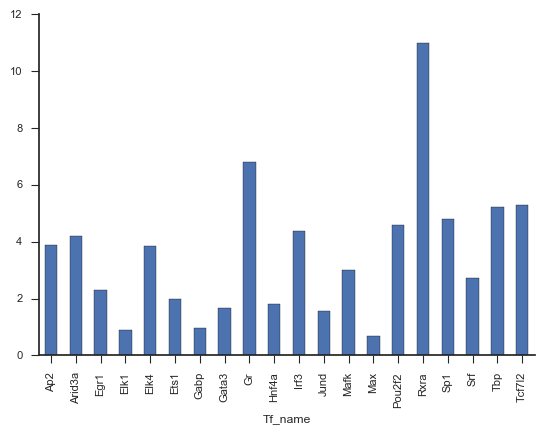

In [25]:
axes = ((TF_scores_noise.T - TF_scores_noise["None"])*100).T["All"].plot.bar()
sns.despine()

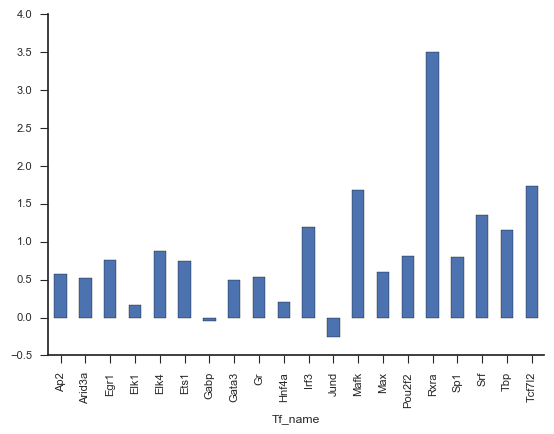

In [26]:
axes = ((TF_scores_noise.T - TF_scores_noise["Noise"])*100).T["All"].plot.bar()
sns.despine()

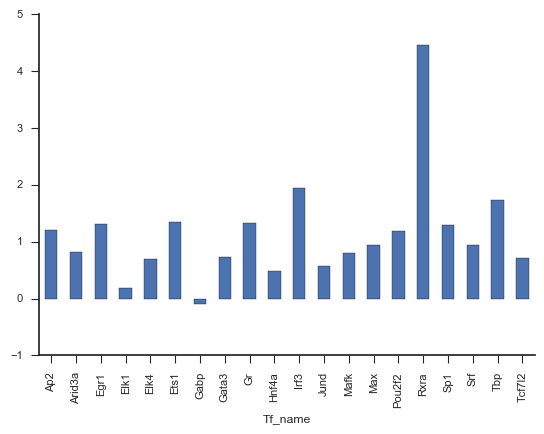

In [27]:
axes = ((TF_scores_noise.T - TF_scores_noise["Preferred"])*100).T["All"].plot.bar()
sns.despine()

### 8. The contribution of various conservation features

Interestingly, this breaks my previous assumption that geting conservation information from a hit site is more informative that getting similar information from the whole sequence. 

We observe a significant improvement in model perfomance when the conservation score are used compared to that without (0.023073981745790676,Wicoxon;-0.65656562523773154, Cohens effect size)

The choice of a stacked bar plot is to highlight the TF-specific contribution of the features to model's perfromance. 


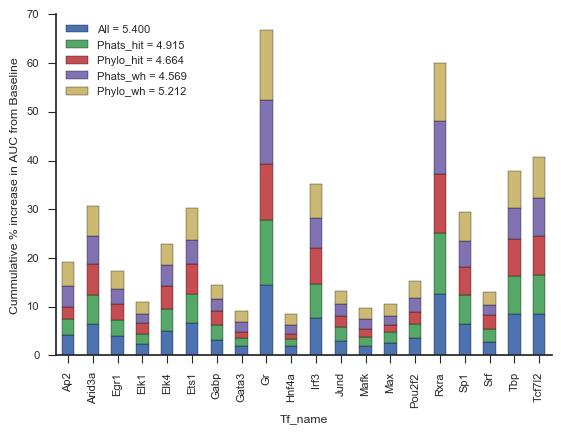

In [28]:
TF_scores_conservation= pd.read_table("../Results/TF_scores_feature_importance_recursive_conservation.txt", index_col="Tf_name")
del TF_scores_conservation["Unnamed: 7"]
conservation_df = ((TF_scores_conservation.T - TF_scores_conservation["None"])*100).T
del conservation_df["None"]
conservation_df = conservation_df.T
#noise_df["Ave"] = noise_df.T.mean()

axes = conservation_df.T.plot.bar(stacked=True)
ave_conserve = conservation_df.T.mean()
leg = list(conservation_df.T.columns)
new_leg = []
for i in leg:
    new_leg.append("%s = %.3f" % (i,ave_conserve[i]))
    
axes.legend(new_leg,loc='best')
axes.set_ylabel("Cummulative % increase in AUC from Baseline")
sns.despine()
plt.savefig("%s/feature_importance_conservation_stacked.pdf" % figure_path, bbox_inches='tight')

In [248]:
#conservation_df.T.plot.box()

In [29]:
get_stat_wilcoxon_effect_size(TF_scores_conservation.None, TF_scores_conservation.Phylo_wh)

(0.034866371928888924, 0.62840849060654302)

In [30]:
get_stat_wilcoxon_effect_size(TF_scores_conservation.Phylo_hit, TF_scores_conservation.None)

(0.065855484238296555, -0.56124850198949483)

In [31]:
wilcoxon(TF_scores_conservation.None, TF_scores_conservation.Phats_hit)

WilcoxonResult(statistic=0.0, pvalue=8.8574576878635487e-05)

In [32]:
get_stat_wilcoxon_effect_size(TF_scores_conservation.None, TF_scores_conservation.Phats_wh)

(0.058290580139488749, 0.54635040425882542)

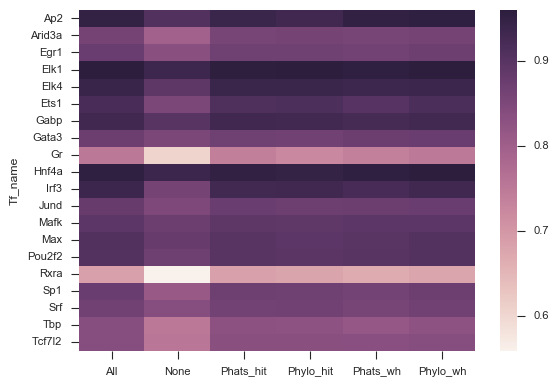

In [33]:
sns.heatmap(TF_scores_conservation)

### 9. How well the models can generalize to other cell types

Little variation in th AUC scores in different cell lines is observed. 

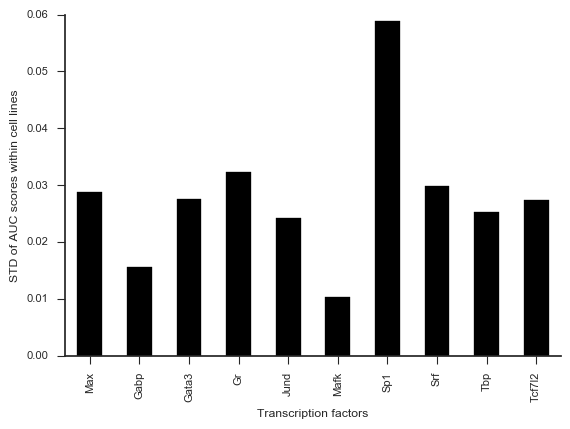

In [34]:
TF_scores_cell_type= pd.read_table("../Results/TF_scores_cell_type_specificity_1.txt", header=None)
TF_scores_cell_type = TF_scores_cell_type.T
axes = (TF_scores_cell_type.T.set_index(0).T.std()).plot(kind="bar", cmap='gray')
axes.set_ylabel("STD of AUC scores within cell lines")
axes.set_xlabel("Transcription factors")
sns.despine()

plt.savefig("%s/feature_importance_cell_type_std.pdf" % figure_path, bbox_inches='tight')

#### a) Get the figures for each TF

The heatmaps that follow show how the models trained on one cell line can predict binding in the other. 

In [36]:
def get_from_clip(Tf_name=""):
    Tf_cell = pd.read_table("../Results/cell_lines/%s.txt" % Tf_name, header=None)
    Tf_cell.set_index(0, inplace=True)
    Tf_cell.columns = Tf_cell.index
    ax=sns.heatmap(Tf_cell, annot=True)
    ax.set_ylabel("Model's predictive ability")
    ax.set_xlabel("Cell line's ease of prediction")
    plt.savefig("%s/cell_line_specificity_%s.pdf" % (figure_path,Tf_name),bbox_inches='tight')

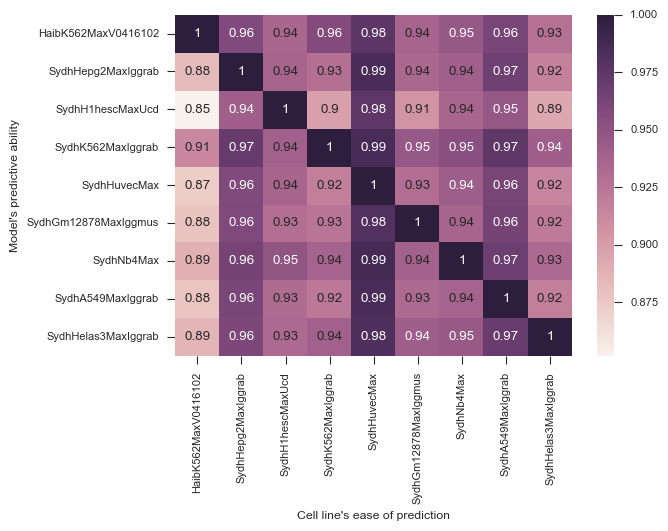

In [37]:
a = get_from_clip("Max")

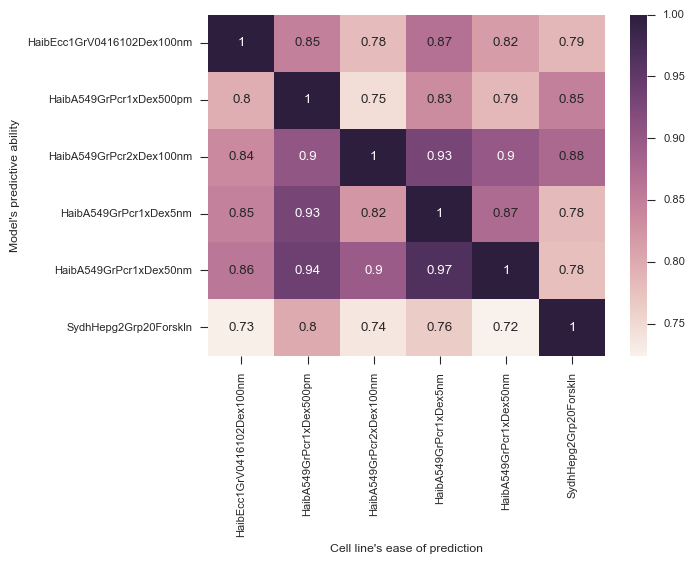

In [38]:
a = get_from_clip("Gr")

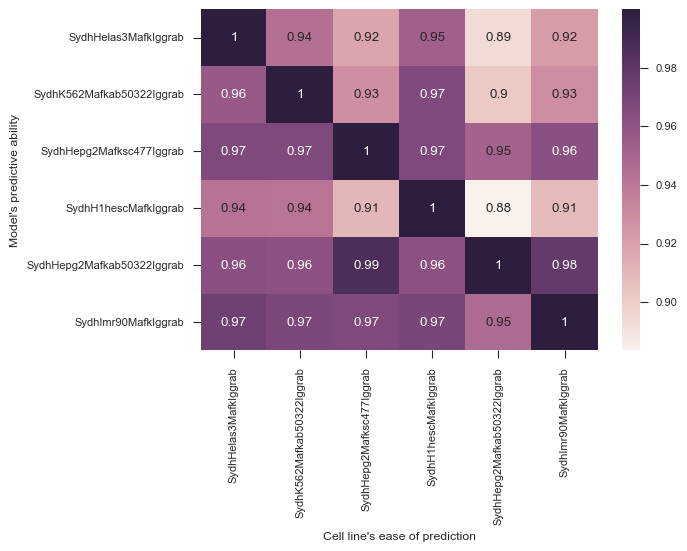

In [39]:
a = get_from_clip("Mafk")

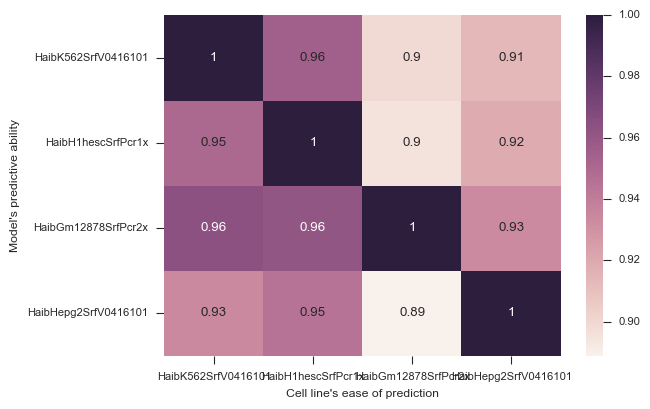

In [40]:
a = get_from_clip("Srf")

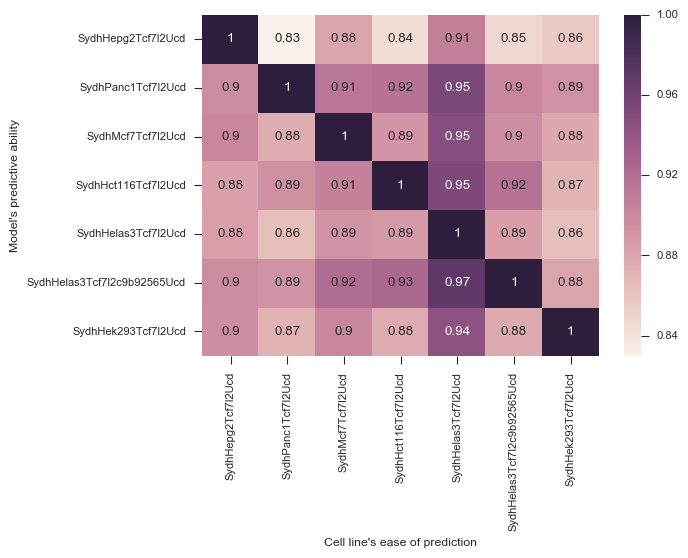

In [41]:
a = get_from_clip("Tcf7l2")

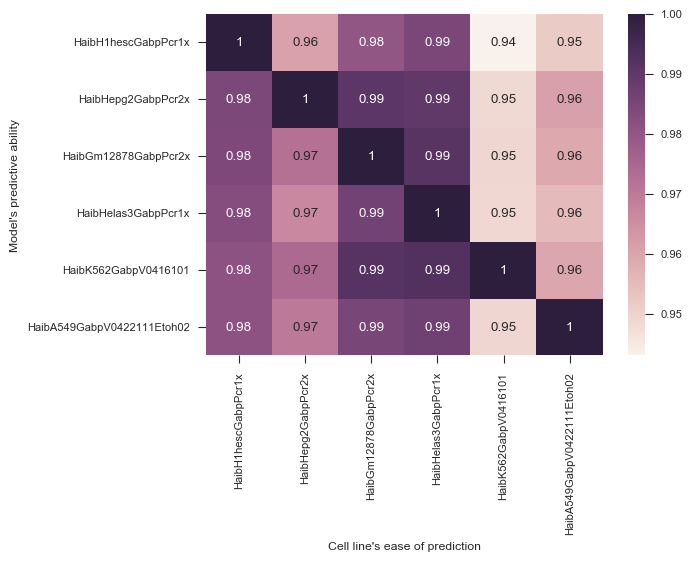

In [42]:
a = get_from_clip("Gabp")

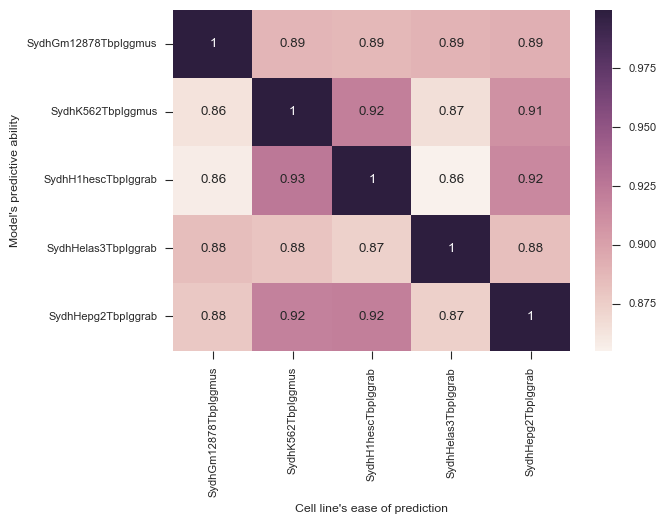

In [43]:
a = get_from_clip("Tbp")

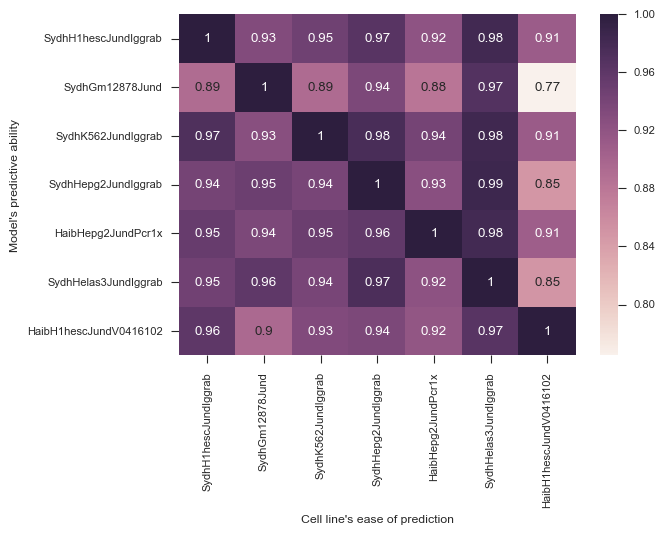

In [44]:
a = get_from_clip("Jund")

## Test all models

In [45]:
all_cl = pd.read_table("../Results/TF_scores.txt", index_col="Tf_name")

all_cl["pwm_score"] = 1-all_cl["pwm_score"]
del all_cl["Unnamed: 14"]

#Quickly map alll the data in different names
map_names["HelT_shape"] = "HelT"
map_names['MGW_shape'] = 'MGW'
map_names['ProT_shape'] = 'ProT'
map_names['Roll_shape'] = 'Roll'
map_names["AUC"] = "XGBoost"
map_names["AUPRC"] = "AUPRC"
map_names["pwm_score"] = "PWM_score"
all_cl = map_names_fun(all_cl)

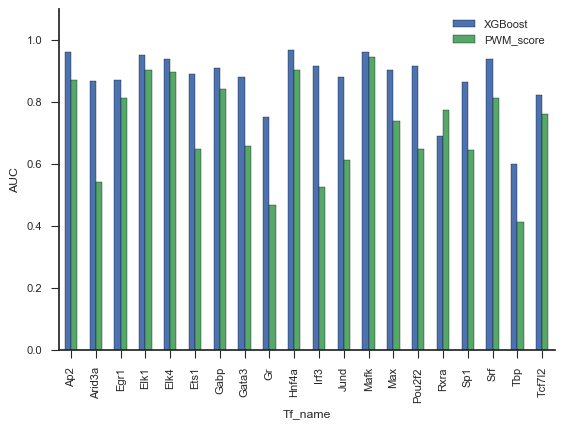

In [46]:
axes = all_cl[["XGBoost","PWM_score"]].plot(kind="bar")
axes.set_ylabel("AUC")
axes.set_ylim(0,1.1)
sns.despine()
plt.savefig("%s/machine_learning_benefit.pdf" % figure_path, bbox_inches='tight')

### 10. Multifeatured model always better predictive than PWM or *k*-mer models on their own.

We show that the use of multiple features improves predictive ability compared with the *k*-mer models on their own.

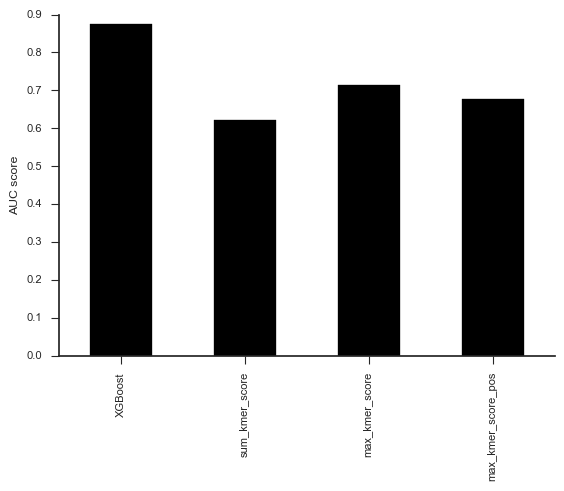

In [47]:
all_cl.index.name = ["XGBoost", "sum_kmer_score", "max_kmer_score", "max_kmer_score_pos"]
all_mean = all_cl[["XGBoost", "sum_kmer_score", "max_kmer_score", "max_kmer_score_pos"]].mean()
all_std = all_cl[["XGBoost", "sum_kmer_score", "max_kmer_score", "max_kmer_score_pos"]].std()
ax = all_mean.plot(kind="bar", cmap='Greys_r')
ax.set_ylabel("AUC score")
sns.despine()
plt.savefig("%s/feature_kmer_scoring.pdf" % figure_path, bbox_inches='tight')

In [48]:
get_stat_wilcoxon_effect_size(all_cl.PWM_score, all_cl.sum_kmer_score)

(0.065855484238296555, -0.66966080402908323)

## Contigency table

Shows which features contribute unique information. 

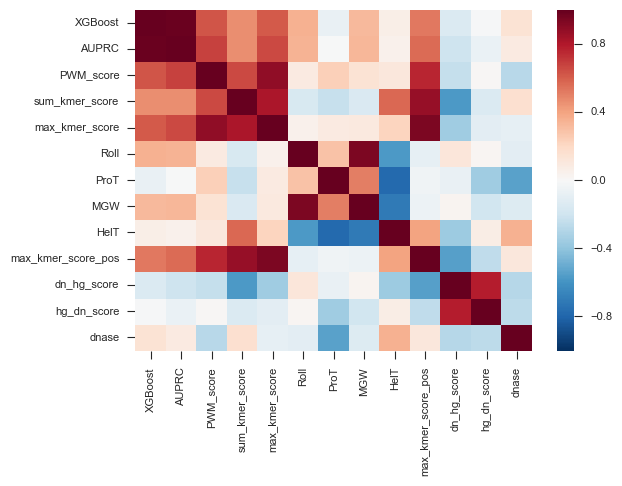

In [49]:
sns.heatmap(all_cl.corr())
plt.savefig("%s/feature_contigency.pdf" % figure_path, bbox_inches='tight')

## Additional stuff--can be removed

In [50]:
feat_imp = pd.read_table("../Results/TF_scores_feature_importance_recursive.txt", index_col="Tf_name")
feat_imp = feat_imp.T
feat_imp["Ave."] = feat_imp.T.mean()
feat_imp = feat_imp.T

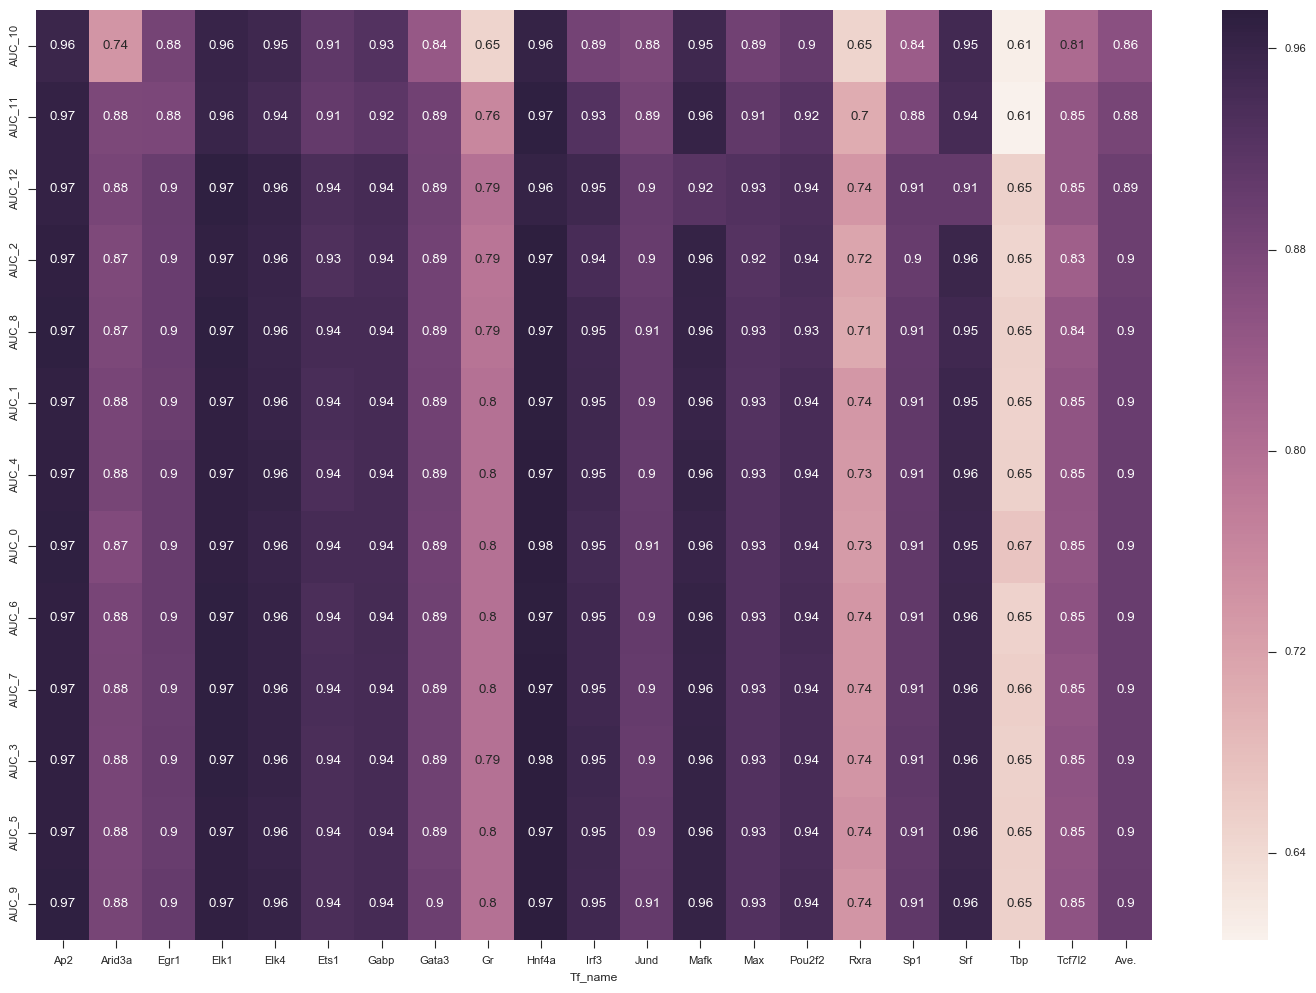

In [51]:
#sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
fig, ax1 = plt.subplots(figsize=(18, 12))
sns.heatmap(feat_imp.T.head(13).sort_values(by="Ave."), annot=True)
#fig = ax.get_figure()
plt.savefig('%s/feature_importance.pdf' % figure_path, bbox_inches='tight')

In [16]:
feat_list = ['kmer_score',
 'max_kmer_score',"phatsCons",
 'Roll_shape', 'ProT_shape', 'MGW_shape', 'HelT_shape',
 'max_kmer_score_pos',
 'dn_hg_score',
 'dn_hg_score2',
 'dnase', "tss_dist","pwm_score"]

In [96]:
test_scores = pd.read_table("TF_scores.txt")
test_scores['pwm_score'] = 1-test_scores['pwm_score']
test_scores = test_scores.drop("Unnamed: 14", 1)
test_scores.set_index("Tf_name", inplace=True)
test_scores["dn_hg_score"] = 1 - test_scores["dn_hg_score"]

### Combining PBM and DNase plots

In [97]:
combined_list = ['Tcf3', 'Hnf4a', 'Foxa2', 'Irf3', 'Tbp', 'Irf4', 'Ap2',
 'Max','Sp4', 'Jund', 'Nr2f2', 'Gata3', 'Arid3a', 'Srf', 'Tcf7l2', 'Gabp',
 'Egr1', 'Rxra', 'Mafk', 'Sp1']

In [270]:
plot_df = pd.DataFrame(columns=["Tf_name", "Sticky", "minmax","minabs", "observed"])
for tf in combined_list:
    tfs = name2pbmchip[tf]
    energy = "/home/kipkurui/Project/PBM_DNase/Results/PBM_Reranked/%s/%s.max_kmer" % (tf.capitalize(), tf.lower())
    #new_test = test.append(pd.read_table(energy, index_col="Motif"))
    new_test = pd.read_table(energy, index_col="Motif")
    new_test.sort_values("AUC", ascending=False, inplace=True)
    # Use this to add each to a specific column fro plotting purpose
    #print tf
    sticky = new_test[new_test.index.str.contains("sticky")]["AUC"].mean()
    minmax = new_test[new_test.index.str.contains("minmax")]["AUC"].mean()
    minabs = new_test[new_test.index.str.contains("minabs")]["AUC"].mean()
    observed = new_test[new_test.index.str.contains("observed")]["AUC"].mean()
    #scaled = new_test[new_test.index.str.contains("scaled")]["AUC"].mean()
    
    df2 = pd.DataFrame([[tf, sticky,minmax,minabs,observed]], columns=["Tf_name","Sticky", "minmax","minabs", "observed"])
    plot_df = plot_df.append(df2)
    
    #print new_test
plot_df.set_index("Tf_name", inplace=True)
plot_df.sort_values(by="Sticky", ascending=False, inplace=True)
plot_df.plot(kind="bar")

NameError: name 'name2pbmchip' is not defined

In [132]:
wilcoxon(plot_df.Sticky, plot_df.observed)

WilcoxonResult(statistic=102.5, pvalue=0.92562714910176558)

In [79]:
sticky_kmer = """CCCCGCCC
AAAAAAAA
GAAAAAAA
GGAAAAAA
CGAAAAAA
ATTATTTA
ATATTAAA
AGAACAAA
TTAATAAA
AACAAAAA
AATTAATA
ATAAATTA
GGAGATAA
ATAAAAAG
GGTAACAA
GAGATAAA
AATAAATA
AAATGATA
ATTTGTTC
AAGAACAA
ATAAACGA
ACAAAGAA
AAAACAAA
GGGGGAGA
GGGGGAAA
GTGGGGAA
AACAATAT
TTGATAAA
CATAACAA
AATATTAA
CCGCCCCA
GGTGGGGA
CCATAACA
AACCAAAA
AATTATCA
GGCGGGGA
TTATAAAA
ATTAGATG
ATAAGAAA
ATTAAAAA
TAACAAAA
CCCTCCCC
ATTTTACC
TTAAAAAA
AACTAATA
AACAAGAA
AGTAGGGG
ATAATAAA
TATAAAAA
AGTTTTAT""".split()

In [ ]:
hg_dn = dn_gapless.copy()
dn_hg = dn_gapless.copy()

hg_dn["counts"] = (hg_gapless["counts"]/sum(hg_gapless["counts"])) - (dn_gapless["counts"]/sum(dn_gapless["counts"]))
dn_hg["counts"] = (dn_gapless["counts"]/sum(dn_gapless["counts"])) - (hg_gapless["counts"]/sum(hg_gapless["counts"]))

In [83]:
hg_dn = pd.read_table("dn_hg_max_normalized.txt")

In [85]:
sticky = hg_dn.ix[sticky_kmer]

In [87]:
sticky = pd.read_clipboard()

In [91]:
sticky.set_index("k-mers", inplace=True)

In [94]:
import matplotlib

In [120]:
sticky.to_csv("sticky_kmers_hg_dn.txt", sep="\t")

## Sticky k-mer figure

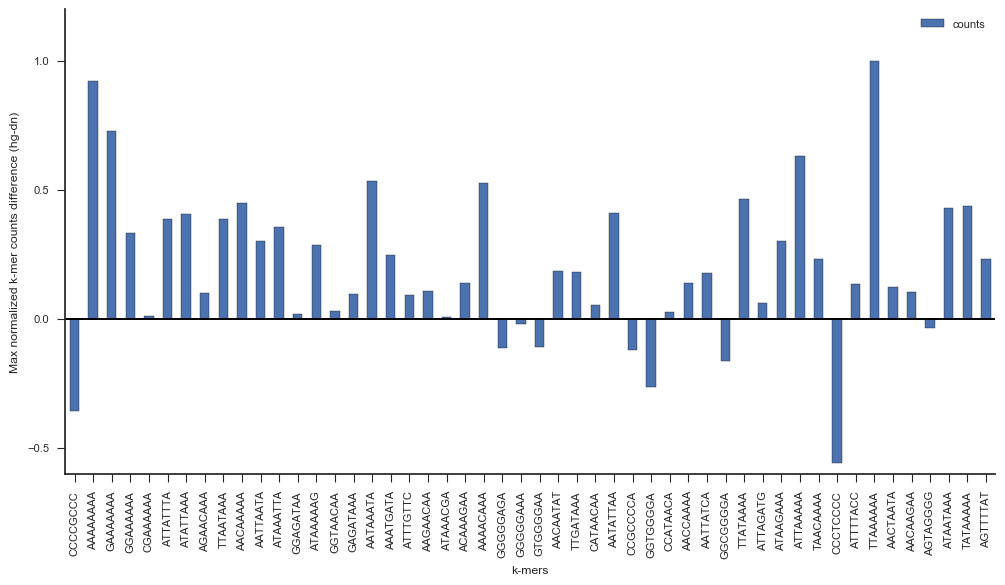

In [52]:
# sticky = hg_dn.ix[sticky_kmer]
# sticky = sticky/sticky["counts"].max()
#matplotlib.style.use('ggplot')
sticky = pd.read_table("../Results/sticky_kmers_hg_dn.txt", index_col="k-mers")
ax = sticky.plot(kind='bar', figsize=(12,6))
sns.despine()
ax.set_ylabel("Max normalized k-mer counts difference (hg-dn)")
plt.axhline(0, color='k')
plt.savefig("%s/sticky_kmer_bar.pdf" % figure_path, bbox_inches='tight')